# Modeling

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

#load data
house_data = pd.read_csv('data_proj.csv')
house_data.head(5)

,SquareFootageStructure,LotSquareFootage,YearBuilt,Bedrooms,BathsTotal,field_StoriesTotal,population,total_income,ListPrice
0,3884.0,16013.0,1978.0,3.0,3.0,1.0,25374.0,4367172.0,2599000.0
1,1164.0,6611.0,1961.0,3.0,2.0,1.0,63557.0,952039.0,499999.0
2,2766.0,7331.0,1986.0,4.0,3.0,2.0,34017.0,1538628.0,929800.0
3,3339.0,20473.0,2001.0,4.0,4.0,1.0,39121.0,1205910.0,689900.0
4,1400.0,7728.0,1910.0,4.0,2.0,1.0,2030.0,15729.0,245000.0


In [63]:
#divide house_data into data and labels
house_data = np.array(house_data)
data = house_data[..., 0:8]
labels = house_data[..., 8]

#split data & labels into training and testing sets
train_ratio = 0.9
split = round(train_ratio*data.shape[0])
data_train = data[: split]
data_test = data[split :]
labels_train = labels[: split]
labels_test = labels[split :]
print('done')

done


In [64]:
#We use standard normalization on our features
mean = data_train.mean(axis = 0)
data_train = data_train - mean
std = data_train.std(axis = 0)
data_train = data_train / std
data_test -= mean
data_test /= std
print('done')

done


In [65]:
#build model
def build_model():
    model = tf.keras.models.Sequential([
        layers.Dense(8, activation='relu', input_shape=(data_train.shape[1],)),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),        
        layers.Dense(1)
    ])                 
    model.compile(loss='mse', optimizer=tf.keras.optimizers.RMSprop(learning_rate = 1e-3), metrics=['mae'])
    return model
model = build_model()
model.summary()
print('done')

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_83 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_84 (Dense)             (None, 128)               1152      
_________________________________________________________________
dense_85 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_86 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_87 (Dense)             (None, 1)                 33        
Total params: 11,593
Trainable params: 11,593
Non-trainable params: 0
_________________________________________________________________
done


In [66]:
#k-fold validation
k = 4
num_epochs = 40
all_scores = []
num_val_samples = len(data_train)//k
for i in range(k):
    print('processing fold #', i)
    val_data = data_train[i * num_val_samples : (i + 1) * num_val_samples]
    val_labels = labels_train[i * num_val_samples : (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate([data_train[: i * num_val_samples], data_train[(i + 1) * num_val_samples :]], axis=0)
    partial_train_labels = np.concatenate([labels_train[: i * num_val_samples], labels_train[(i + 1) * num_val_samples :]], axis=0)
    
    model = build_model()
    model.fit(partial_train_data, partial_train_labels,
              epochs=num_epochs, batch_size=5, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_labels, verbose=0)
    all_scores.append(val_mae)
    print(val_mae)

processing fold # 0
239107.75
processing fold # 1
242472.17
processing fold # 2
216530.98
processing fold # 3
244393.53


In [67]:
print(all_scores)

[239107.75, 242472.17, 216530.98, 244393.53]


In [94]:
# Average validation MAE
print(np.mean(all_scores))

235626.12


In [68]:
# We are going to save the train loss, validation loss, train accuracy (mae), and validation accuracy (mae)
# for each processing fold.
num_epochs = 40
val_loss_histories = []
val_mae_histories = []
train_loss_histories = []
train_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    val_data = data_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = labels_train[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [data_train[:i * num_val_samples],
         data_train[(i + 1) * num_val_samples:]],
        axis = 0)
    
    partial_train_labels = np.concatenate(
        [labels_train[:i * num_val_samples],
         labels_train[(i + 1) * num_val_samples:]],
        axis = 0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_labels,
                        validation_data = (val_data, val_targets),
                        epochs = num_epochs, batch_size = 5, verbose=0)
    val_loss = history.history['val_loss']
    val_mae = history.history['val_mae']
    train_loss = history.history['loss']
    train_mae = history.history['mae']
    val_loss_histories.append(val_loss)
    val_mae_histories.append(val_mae)
    train_loss_histories.append(train_loss)
    train_mae_histories.append(train_mae)
print(history.history.keys())

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


In [92]:
# We take the average for all of the k groups, for each epoch. So, our result is going to be an array of 40 elements
average_loss_val_history = [
    np.mean([x[i] for x in val_loss_histories]) for i in range(num_epochs)]
print('done')

done


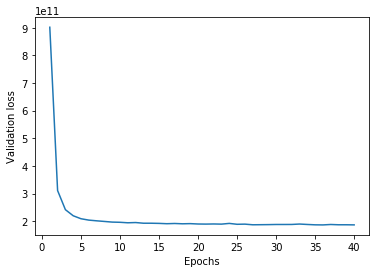

In [70]:
# average_loss_val_history
plt.plot(range(1, len(average_loss_val_history) + 1), average_loss_val_history)
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.show()

In [71]:
average_loss_train_history = [
    np.mean([x[i] for x in train_loss_histories]) for i in range(num_epochs)]
print('done')

done


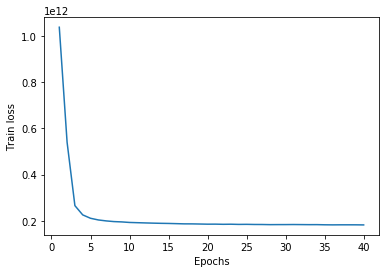

In [72]:
# average_loss_train_history
plt.plot(range(1, len(average_loss_train_history) + 1), average_loss_train_history)
plt.xlabel('Epochs')
plt.ylabel('Train loss')
plt.show()

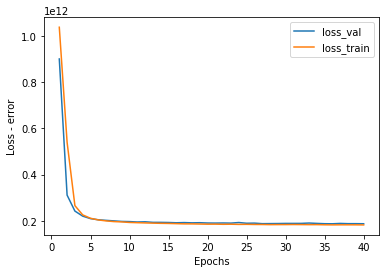

In [73]:
# average_loss_train_history and # average_loss_val_history
plt.plot(range(1, len(average_loss_val_history) + 1), average_loss_val_history, label = 'loss_val')
plt.plot(range(1, len(average_loss_train_history) + 1), average_loss_train_history, label = 'loss_train')
plt.xlabel('Epochs')
plt.ylabel('Loss - error')
plt.legend(loc='upper right')
plt.show()

In [74]:
average_mae_val_history = [
    np.mean([x[i] for x in val_mae_histories]) for i in range(num_epochs)]
print('done')

done


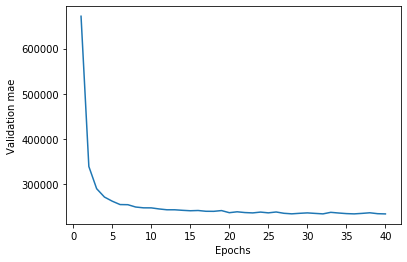

In [75]:
# average_mae_val_history

plt.plot(range(1, len(average_mae_val_history) + 1), average_mae_val_history)
plt.xlabel('Epochs')
plt.ylabel('Validation mae')
plt.show()

In [76]:
average_mae_train_history = [
    np.mean([x[i] for x in train_mae_histories]) for i in range(num_epochs)]
print('done')

done


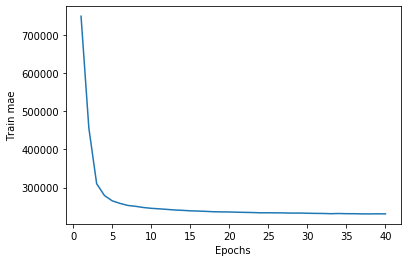

In [77]:
# average_mae_train_history 

plt.plot(range(1, len(average_mae_train_history) + 1), average_mae_train_history)
plt.xlabel('Epochs')
plt.ylabel('Train mae')
plt.show()

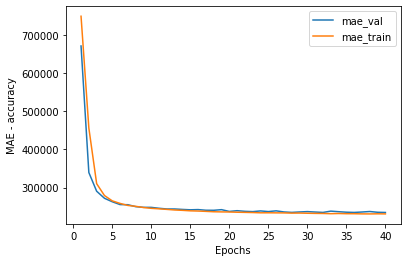

In [78]:
# average_mae_train_history and average_mae_val_history

plt.plot(range(1, len(average_mae_val_history) + 1), average_mae_val_history, label = 'mae_val')
plt.plot(range(1, len(average_mae_train_history) + 1), average_mae_train_history, label = 'mae_train')
plt.xlabel('Epochs')
plt.ylabel('MAE - accuracy')
plt.legend(loc='upper right')
plt.show()

In [79]:
# TESTING

model = build_model()
model.fit(data_train, labels_train,
          epochs = 80, batch_size = 5, verbose = 0)
test_mse_score, test_mae_score = model.evaluate(data_test, labels_test, verbose=0)
print('done')

done


In [80]:
# Testing mae score
test_mae_score

244023.22

In [95]:
# Linear Regression algorithm - Scikit Learn

from sklearn.linear_model import LinearRegression

scikit_house = LinearRegression()
scikit_house.fit(data_train, labels_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [96]:
scikit_pred_house = scikit_house.predict(data_train)

In [97]:
def mae(y_hat, y):
    return np.mean(np.abs(y - y_hat))

In [99]:
mae_scores = mae(scikit_pred_house, labels_train)

In [102]:
print(mae_scores)

270629.45000313007


In [101]:
scikit_pred_test = scikit_house.predict(data_test)
scikit_test_scores = mae(scikit_pred_test, labels_test)
print(scikit_test_scores)

293669.1998747875


In [ ]:
# Using the testing set, we got an accuracy of around 293,669